# **P2. Investigate a Dataset**

# Chosen Dataset: No Show Appointments

This dataset collects information from 100k medical appointments in Brazil and is focused on the question of whether or not patients show up for their appointment.    
[Referece](https://www.kaggle.com/joniarroba/noshowappointments)

# Data Dictionary
PatientId - Identification of a patient    
AppointmentID - Identification of each appointment    
Gender = Male or Female   
DataMarcacaoConsulta = The day of the actuall appointment, when they have to visit the doctor   
DataAgendamento = The day someone called or registered the appointment, this is before appointment of course    
Age = How old is the patient   
Neighbourhood = Where the appointment takes place    
Scholarship = Ture of False    
Hipertension = True or False    
Diabetes = True or False    
Alcoholism = True or False    
Handcap = True or False    
SMS_received = 1 or more messages sent to the patient    
No-show = True or False    
[Reference](https://www.kaggle.com/joniarroba/noshowappointments)

# Data Summary Initial Investigation

## Load Data

In [132]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets, linear_model
import math
from statsmodels.graphics.mosaicplot import mosaic
from seaborn import heatmap
from scipy.stats import poisson
%matplotlib inline

In [133]:
file = "noshowappointments-kagglev2-may-2016.csv"

record = pd.read_csv(file)
record.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


In [4]:
record.describe()

,PatientId,AppointmentID,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received
count,1.105270e+05,1.105270e+05,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000
mean,1.474963e+14,5.675305e+06,37.088874,0.098266,0.197246,0.071865,0.030400,0.022248,0.321026
std,2.560949e+14,7.129575e+04,23.110205,0.297675,0.397921,0.258265,0.171686,0.161543,0.466873
min,3.921784e+04,5.030230e+06,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.172614e+12,5.640286e+06,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.173184e+13,5.680573e+06,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,9.439172e+13,5.725524e+06,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,9.999816e+14,5.790484e+06,115.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000


## Initial Observation

This dataset uses PatientId to identify each patient, and AppointmentID to identify each appointment. It can be predicted that the AppointmentID is unique. Other variables include categorical variables such as Gender, Neighbourhood, Scholarship, Hipertension, Diabetes, Alcoholism, Hand(i)cap, SMS_received, where Neighbourhood has more than 2 categories. Numerical variables include, ScheduledDay, AppointmentDay and Age, where ScheduleDay and AppointmentDay are time series data.

Here is a list of assumptions I am making.
1. ScheduledDay should alwasy be on the same day or before AppointmentDay.
2. Age should always be larger or equal to 0.
3. SMS_received can be both numerical or categorical, but I guessed the SMS sent will not by more than 3 from my life experience. The categorization strategy will be updated as more investigation has been implemented.
4. Handcap is not binary which is different from the data dictionary. 

The assumptions will be checked before data analysis.

---

## NA value Investigation

In [5]:
len(record) == len(record.dropna())

True

The data has no NA value

---

# Question Posted

The following report will focus on answering the following question approaching from different perspectives.

**What factors are important for us to know in order to predict if a patient will show up for their scheduled appointment?**

# Patient ID Analysis

The appointment ID is unique, but the patient can be a returning patient. Let's have a look at the unique patient.

In [6]:
print("The number of unique patient is", str(len(record["PatientId"].unique())))
print("The number of unique Appointment ID is", str(len(record["AppointmentID"])))

The number of unique patient is 62299
The number of unique Appointment ID is 110527


The unique patient is about half of the appointment. Let's aggregate the count for each patient ID and find out more about the returning visitors.

In [7]:
patient = pd.DataFrame(record["PatientId"].value_counts())
patient.iloc[:10]

,PatientId
8.221459e+14,88
9.963767e+10,84
2.688613e+13,70
3.353478e+13,65
2.584244e+11,62
7.579746e+13,62
8.713749e+14,62
6.264199e+12,62
6.684488e+13,57
8.722785e+11,55


In [8]:
patient["PatientId"].describe()

count    62299.000000
mean         1.774138
std          1.770324
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max         88.000000
Name: PatientId, dtype: float64

The table above shows the most frequent visitors. The most frequent visitor visited the clinic 88 times in the time frame, the second most frequent visitor visited the clinic 84 times, and the third visited 70 times. From the five number summary, it is quite clear that most of the people come in once or twice. However, there are quite a few people come in more than two times. I will look closer to those frequent visitors and unfrequent visitors.

In [188]:
patient_count = pd.DataFrame(patient["PatientId"].value_counts())
patient_count.columns = ["PatientId_count"]
patient_count["ratio"] = patient_count["PatientId_count"]/len(patient)
patient_count.iloc[:10]

,PatientId_count,ratio
1,37920,0.608678
2,13895,0.223037
3,5500,0.088284
4,2367,0.037994
5,1119,0.017962
6,553,0.008877
7,306,0.004912
8,202,0.003242
9,104,0.001669
10,85,0.001364


In [196]:
count_larger_5 = patient_count.loc[5:,"PatientId_count"].sum()
ratio_larger_5 = patient_count.loc[5:,"ratio"].sum()
new_row = {"PatientId_count": count_larger_5, "ratio":ratio_larger_5}
patient_count_subdf = patient_count.iloc[0:4].copy()
patient_count_subdf=patient_count_subdf.append(new_row, ignore_index=True)
patient_count_subdf["ratio"] = patient_count_subdf["PatientId_count"]/len(patient)

Text(0.5,1,'The Ratio of Time of Visits Takes in Total Appointments')

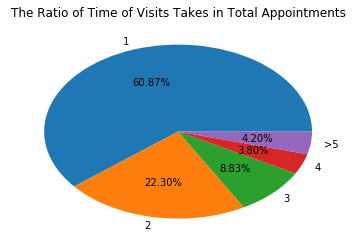

In [197]:
pie_plt = plt.pie(patient_count_subdf["ratio"], labels=["1", "2", "3" ,"4", ">5"], autopct='%1.2f%%')
plt.title("The Ratio of Time of Visits Takes in Total Appointments")

In [11]:
unfrequent_visitor = round(sum(patient_count["ratio"][0:3]), 2)*100
print("The ratio of the visitors who visit clinic under three times is", str(unfrequent_visitor), "%")

The ratio of the visitors who visit clinic under three times is 92.0 %


The pie chart and the table above show 60.9% of the people go to clinic only once, 22.3% of them go to clinic twice, and 8.8% go to clinic 3 times. People who visit under three times take 92% of the total unique patients. I will define people who go to clinic under or equal to 3 times as frequent visitors and more than 3 times as frequent visitors.

**Q1. What ratio of appointments do frequent visitors contribute to total appointment?**

In [12]:
frequent_visitors = patient[patient["PatientId"]>3].copy()
print("The number of frequent visitors is", str(len(frequent_visitors)),
      ", and it is", str(round(len(frequent_visitors)/len(patient), 2)*100), "% of the total unique visitors.")
frequent_visitors.reset_index(inplace=True)
frequent_visitor_id = frequent_visitors["index"].tolist()
frequent_visitor_no_show = record[["PatientId", "No-show"]].copy()
is_frequent = lambda x: x in frequent_visitor_id
vfunc = np.vectorize(is_frequent)
frequent_visitor_no_show["is_frequent"] = vfunc(frequent_visitor_no_show["PatientId"])
is_freq_count = frequent_visitor_no_show.set_index("PatientId")
is_freq = pd.DataFrame(is_freq_count["is_frequent"].value_counts())
is_freq["ratio"]=is_freq["is_frequent"]/len(record)


The number of frequent visitors is 4984 , and it is 8.0 % of the total unique visitors.


Text(0.5,1,'Pie Plot for Appointments Made by Frequent Patients')

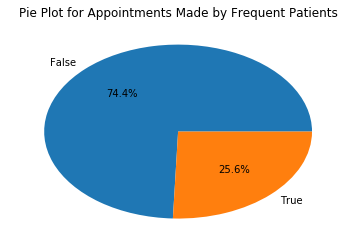

In [15]:
pie_plot_freq = plt.pie(is_freq["ratio"], labels=is_freq.index, autopct='%1.1f%%')
plt.title("Pie Plot for Appointments Made by Frequent Patients")

The above analysis shows when we set threshold as 3 for frequent visitors, 25.6% of appointments are made by frequent visitors which is much larger than 8.0% being the total unique visitors.

**Q2. How does the ratio of visits by frequent visitors change if we set threshold higher?**

According to the frequency distribution, however, we can predict that the ratio of visists by frequent visitor out of total visits will decrease considerably if we set threshold higher. The following function does exactly that.

In [14]:
def find_freq(threshold):
    row = {}
    row["threshold"] = threshold
    frequent_visitors = patient[patient["PatientId"]>threshold].copy()
    row["frequent_visitors"] = len(frequent_visitors)
    row["portion_unique_visitor"] = round(len(frequent_visitors)/len(patient), 2)*100
    frequent_visitors.reset_index(inplace=True)
    frequent_visitor_id = frequent_visitors["index"].tolist()
    frequent_visitor_no_show = record[["PatientId", "No-show"]].copy()
    is_frequent = lambda x: x in frequent_visitor_id
    vfunc = np.vectorize(is_frequent)
    frequent_visitor_no_show["is_frequent"] = vfunc(frequent_visitor_no_show["PatientId"])
    is_freq_count = frequent_visitor_no_show.set_index("PatientId")
    is_freq = pd.DataFrame(is_freq_count["is_frequent"].value_counts())
    is_freq["ratio"]=is_freq["is_frequent"]/len(record)
    row["portion_in_all_appt"] = round(is_freq.loc[1, "ratio"], 4)*100
    return (row)

threshold_nparray = np.array(patient["PatientId"].unique()-1)
threshold_nparray = np.delete(threshold_nparray,[len(threshold_nparray)-1,len(threshold_nparray)-2, len(threshold_nparray)-3])

apply_threshold = np.vectorize(lambda x: find_freq(x))
rows=apply_threshold(threshold_nparray)
get_row_dict = [r for r in rows]
pd.DataFrame(get_row_dict)

,frequent_visitors,portion_in_all_appt,portion_unique_visitor,threshold
0,1,0.08,0.0,87
1,2,0.16,0.0,83
2,3,0.22,0.0,69
3,4,0.28,0.0,64
4,8,0.50,0.0,61
5,9,0.55,0.0,56
6,10,0.60,0.0,54
7,11,0.65,0.0,53
8,12,0.70,0.0,50
9,13,0.74,0.0,49


As shown from the analysis, the ratio of the frequent visitors drop drastically after the threshold increases. The ratio of appointment is lower than 2% the threshold reaches 16, and drops under 1% when the threshold is 37. The ratio of the frequent visitors out of total unique visitors drop below 1% when the number of visits reach 11. 

It was tempting to look at the no-show rate with frequency further, but even the people who drop by 88 times take a small amount of data comparing to the data set. I believe its still safe to assume independency.

**Q3. How is the no-show rate correlated to frequency of people coming to the clinic?**

In [16]:
lookupTable, indexed_dataSet = np.unique(frequent_visitor_no_show["No-show"], return_inverse=True)
frequent_visitor_no_show['No-show-indexed'] = indexed_dataSet
np.corrcoef(frequent_visitor_no_show['No-show-indexed'], frequent_visitor_no_show['is_frequent'])[0][1].round(4)

0.0145

Frequency of people coming to the clinic is slightly positively correlated to no-show rate, which means if a person goes to clinic more often, it is slightly more likely that this person will not show. The threshold chosen here is 3, where there are about one fourth of appointments made by people who visit the clinic more frequent than 3. As shown from Q1.2, as the threshold raises, the frequent visitors take smaller percentage in the total unique patients. Their appointments also take smaller portion of the total appointments. To look at the appointments under 10% may not lose the larger picture of relationship of frequent patients and no-show rate.

**Q4. How does the repeated patients affect the average of the categorical variable?**

If a patient has suffered from Hipertension, Diabetes, Alcoholism or Handicap, I would consider this person as having those diseases due to the chronic nature of the disease or disabilities. The logic of munging this data is to group by patient ID, and add up the number for the column. If the patient record ever appears to be non-zero, I will assign the value as 1. Also, I would assume the gender does not change for that person during the time frame.

In [17]:
chronic = ["PatientId", "Gender", 'Hipertension', "Diabetes", "Alcoholism", "Handcap"]
record_chronic = record[chronic].copy()
lookupTable, indexed_dataSet = np.unique(record_chronic["Gender"], return_inverse=True)
record_chronic["Gender-indexed"] = indexed_dataSet
record_chronic = record_chronic.groupby(record_chronic["PatientId"]).sum()
adjust_to_one = lambda x: x if x==0 else 1
vfunc = np.vectorize(adjust_to_one)
cols_to_adjust = ["Hipertension", "Diabetes", "Alcoholism", "Handcap", "Gender-indexed"]
record_chronic[cols_to_adjust] = record_chronic[cols_to_adjust].apply(vfunc)
record_chronic.drop("PatientId", axis=1, inplace=True)
col1 = record_chronic.describe().loc["mean", ["Hipertension", "Diabetes", "Alcoholism", "Handcap"]]
col1.name = "mean_unique"

In [18]:
col2 = record.describe().loc["mean", ["Hipertension", "Diabetes", "Alcoholism", "Handcap"]]
col2.name = "mean_all_appt"
compare = pd.DataFrame([col1, col2]).T
compare["change_percent"] = ((compare["mean_unique"] - compare["mean_all_appt"])/compare["mean_all_appt"])*100
compare

,mean_unique,mean_all_appt,change_percent
Hipertension,0.196504,0.197246,-0.376162
Diabetes,0.070884,0.071865,-1.364827
Alcoholism,0.024174,0.030400,-20.480617
Handcap,0.018186,0.022248,-18.255473


All of the categorical variables decreased after adjustment, which means there are more people having those chronic diseases come to the clinic more often than people who don't. Alcoholism decreased the most drastically by 20.48%, and then Handcap decreased by 18.26%. The result means people having alcoholism and handcap visit clinics more often than people who don't have them.

---

# Age

**Q5. How is age distributed in the data set and how does it correlate to no-show rate?**

To have a closer look at the numercial data, Age, I use describe() to see the summary of the two variables

In [19]:
record[["Age"]].describe()[1:] ## Not showing the Count value, since Count is not important for this dataset

,Age
mean,37.088874
std,23.110205
min,-1.000000
25%,18.000000
50%,37.000000
75%,55.000000
max,115.000000


In [20]:
age_count = record["Age"].value_counts()
age_count[:9]/len(record)*100

0     3.201933
1     2.056511
52    1.579705
49    1.494657
53    1.493753
56    1.479277
38    1.473848
59    1.469324
2     1.463896
Name: Age, dtype: float64

For all of the appointments, 0-and 1-year old children take 3.2% and 2.1% of the total. Since a patient can visit the clinic more than 1 time, it is expected to have multiple visits from one PatientID. Combining the age into age groups may grasp the larger picture of the age distribution. Also, interestingly, the minimal value for age is -1.

In [21]:
print("The entries with age < 1 is now", str(record[record["Age"] < 0].shape[0]))

The entries with age < 1 is now 1


Since there is no indication of how a lower-than-zero age is documented, age of -1 does not make much sense. I will treat this row as a typo and discard.

In [22]:
record=record[record["Age"] >= 0]

Now, the age range is from 0 to 115. Use a histogram to show the age distribution.

Text(0.5,0,'Age of the Patients')

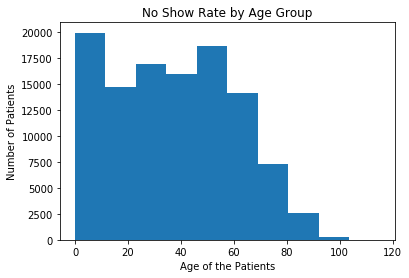

In [23]:
record.index = record["AppointmentID"]
# record["Age"].plot.hist(stacked=True, bins=30)

p = plt.hist(record["Age"])
plt.title('No Show Rate by Age Group')
plt.ylabel('Number of Patients')
plt.xlabel("Age of the Patients")

It seems there are a few "bumps" in age distribution. Age groups 0-15, 25-35 and 50-65 have high frequency. It makes sense because new-borns and elderly are prone to diseases. Age groups of 20-23 and 40-43 have the lowest frequency. The drop in 65 years old is not surprising since more people desease as age grows.    

<strong> Q5.1. Is no-show rate correlated to age? </strong>

First, let's divide people into 6 age groups of 20 years. ie. 0-19, 20-39, 40-59, 60-79, 80-99, 100-118.

In [24]:
record.loc[:,"Age_Group"] = np.array(np.floor(record.Age/20)+1)

In [25]:
record[["Age","Age_Group"]].head()

,Age,Age_Group
AppointmentID,,
5642903,62,4.0
5642503,56,3.0
5642549,62,4.0
5642828,8,1.0
5642494,56,3.0


In [26]:
factors = np.unique(record["Age_Group"], return_inverse=True)[0].tolist()
factors

[1.0, 2.0, 3.0, 4.0, 5.0, 6.0]

In [27]:
## Now let's see the relationship between Age_Group and No Show Rate

no_show_dict = {}
show_dict = {}
for factor in factors:
    no_show_dict[factor] = len(record[(record["Age_Group"] == factor) &(record["No-show"]=="Yes")])
    show_dict[factor] = len(record[(record["Age_Group"] == factor) & (record["No-show"]=="No")])

age_group = ["0-19", "20-39", "40-59", "60-79", "80-99", "100-118"]
df_age_group = pd.DataFrame(data=[no_show_dict,show_dict]).T
df_age_group.rename(columns={0:'No_Show', 1:"Show"}, inplace=True)
df_age_group["No_Show_Rate"] = df_age_group["No_Show"]/(df_age_group["No_Show"]+df_age_group["Show"])
df_age_group["Age_group"] = age_group
df_age_group.round({"No_Show_Rate": 2})



,No_Show,Show,No_Show_Rate,Age_group
1.0,6741,23670,0.22,0-19
2.0,6680,22190,0.23,20-39
3.0,5656,24416,0.19,40-59
4.0,2692,15118,0.15,60-79
5.0,547,2805,0.16,80-99
6.0,3,8,0.27,100-118


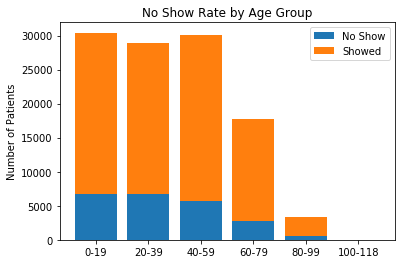

In [28]:
p1 = plt.bar(np.arange(6), df_age_group["No_Show"])
p2 = plt.bar(np.arange(6), df_age_group["Show"], bottom=df_age_group["No_Show"])

plt.title('No Show Rate by Age Group')
plt.ylabel('Number of Patients')
plt.xticks(np.arange(6), ("0-19", "20-39", "40-59", "60-79", "80-99", "100-118"))
plt.legend((p1[0], p2[0]), ('No Show', 'Showed'))

The no show rate slightly correlates to age group as given people in age group 0-19, 20-39, 40-59, 60-79, 80-99, and 100-118, the ratio of people who showed up and people who didn't show up is not the same across all age group. The No Show Rate is about the same for people in age 0-19 and age 20-39. The No Show rate drops after the age hits 40, and continues to remain around 15% until the age grows over 100. Please be noted that the total number of patients in age group 100 and 118 is fairly low (11 people in total). The confidence interval for the no show rate will be expected to be large. <br> <br>

It would be interesting to see the mosaic plot of Age_Group and the No-show Rate

<strong>Q5.2. Given people in different age groups, what is the probability of people do not show up for their appointment?</strong>

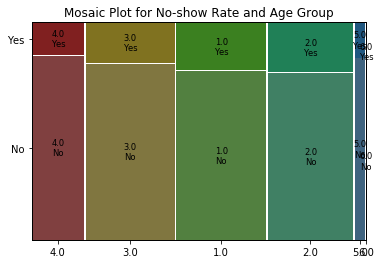

In [121]:
m=mosaic(record, ["Age_Group", "No-show"],title="Mosaic Plot for No-show Rate and Age Group")

From the mosaic plot, people in age groups 0-19, 20-39, 40-59 and 60-79 take the largest portion of the population. When given people in age groups of 0-19 and 20-39, the no-show rate is higher than people in other groups. The mosaic plot shows no-show rate is not independent from age groups.

**Q5.3: What is the correlation between no-show rate to age and to age group?**

In [35]:
lookupTable, indexed_dataSet = np.unique(record["No-show"], return_inverse=True)
record["No-show-indexed"] = indexed_dataSet

The above two blocks of code indicate that "No" for no-show has been coded as 0, and "Yes" for no-show has been coded as 1.

In [36]:
print("The coefficient of No-show and Age Group is "
      + str(np.corrcoef(record["No-show-indexed"], record["Age_Group"])[0][1].round(4)))
print("The coefficient of No-show and Age is "
      + str(np.corrcoef(record["No-show-indexed"], record["Age"])[0][1].round(4)))

The coefficient of No-show and Age Group is -0.0635
The coefficient of No-show and Age is -0.0603


### Categorical Data

To check the categorical data, I use value_counts() for each of the categorical variables

In [37]:
cols = ["Gender", "Scholarship",
        'Hipertension', "Diabetes", "Neighbourhood",
        "Alcoholism", "Handcap", "SMS_received"]
for col in cols:
    print("Table for " + col + " with " + str(len(record[col].value_counts()))+" categories")
    print(record[col].value_counts()[0:7])
    print("\n")
    

Table for Gender with 2 categories
F    71839
M    38687
Name: Gender, dtype: int64


Table for Scholarship with 2 categories
0    99665
1    10861
Name: Scholarship, dtype: int64


Table for Hipertension with 2 categories
0    88725
1    21801
Name: Hipertension, dtype: int64


Table for Diabetes with 2 categories
0    102583
1      7943
Name: Diabetes, dtype: int64


Table for Neighbourhood with 81 categories
JARDIM CAMBURI     7717
MARIA ORTIZ        5805
RESISTÊNCIA        4431
JARDIM DA PENHA    3877
ITARARÉ            3514
CENTRO             3334
TABUAZEIRO         3132
Name: Neighbourhood, dtype: int64


Table for Alcoholism with 2 categories
0    107166
1      3360
Name: Alcoholism, dtype: int64


Table for Handcap with 5 categories
0    108285
1      2042
2       183
3        13
4         3
Name: Handcap, dtype: int64


Table for SMS_received with 2 categories
0    75044
1    35482
Name: SMS_received, dtype: int64




It is surprising to see that "Handcap" is not a binary value. According to this [post](https://www.kaggle.com/joniarroba/noshowappointments/discussion/29699), "the handcap refers to the number of desabilites a person has". If a person is both blind and deaf, Handicap for this person will show 2.  

Although I could use almost the same way to determine the no show rate, I'd like to take a closer look at the correlations among variables.

**Q3.1 What is the correlation between all categorical variables?**

This question can be answered both graphically or mathematically. I'd like to use the mathematical method to discover the correlation to avoid code repetition

In [38]:
cols.extend(["No-show-indexed"])
subdf = record[cols].copy()
subdf.loc[:, "Gender"].replace({"F":0, "M":1}, inplace=True)
subdf.loc[:, "Handcap_or_not"] = subdf.loc[:, "Handcap"].replace({2:1, 3:1, 4:1})
subdf.drop(columns=["Handcap"], inplace=True)
subdf.corr()

,Gender,Scholarship,Hipertension,Diabetes,Alcoholism,SMS_received,No-show-indexed,Handcap_or_not
Gender,1.000000,-0.114296,-0.055722,-0.032556,0.106166,-0.046302,-0.004122,0.022421
Scholarship,-0.114296,1.000000,-0.019730,-0.024894,0.035022,0.001192,0.029134,-0.009104
Hipertension,-0.055722,-0.019730,1.000000,0.433085,0.087970,-0.006270,-0.035704,0.084851
Diabetes,-0.032556,-0.024894,0.433085,1.000000,0.018473,-0.014552,-0.015181,0.059144
Alcoholism,0.106166,0.035022,0.087970,0.018473,1.000000,-0.026149,-0.000197,0.003692
SMS_received,-0.046302,0.001192,-0.006270,-0.014552,-0.026149,1.000000,0.126428,-0.025221
No-show-indexed,-0.004122,0.029134,-0.035704,-0.015181,-0.000197,0.126428,1.000000,-0.007281
Handcap_or_not,0.022421,-0.009104,0.084851,0.059144,0.003692,-0.025221,-0.007281,1.000000


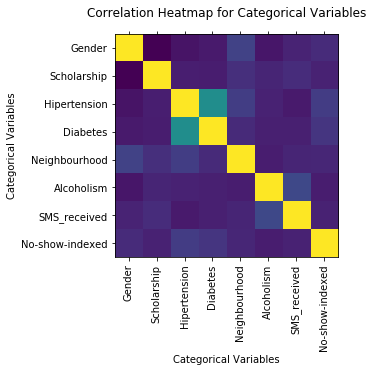

In [114]:
plt.matshow(subdf.corr())
plt.title("Correlation Heatmap for Categorical Variables")
plt.ylabel("Categorical Variables")
plt.yticks(np.arange(8), list(subdf))
plt.xlabel("Categorical Variables")
plt.xticks(np.arange(8), list(subdf), rotation='vertical')
plt.tick_params(axis='x', bottom=True, labelbottom=True, labeltop=False)


In [169]:
np.corrcoef(record["Diabetes"].tolist(), record["Hipertension"].tolist())[0][1].round(2)

0.43

The correlation coefficient for Hipertension and Diabetes is 0.42, and is much higher than the correlation for any other pairs of variables. To further demonstrate this, I created a mosaic plot.

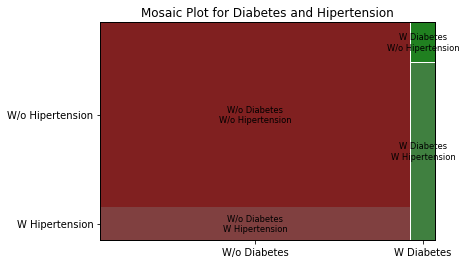

In [124]:
observe_corr = pd.DataFrame(record[["Diabetes", "Hipertension"]]).copy()
observe_corr["Diabetes"].replace({0: "W/o Diabetes", 1:"W Diabetes"}, inplace=True)
observe_corr["Hipertension"].replace({0:"W/o Hipertension", 1:"W Hipertension"}, inplace=True)

mos=mosaic(observe_corr, ["Diabetes", "Hipertension"], title="Mosaic Plot for Diabetes and Hipertension")

The mosaic plot shows a big difference on the possibiity of Hipertension is Yes given diabete is No, and the possibilty of Hipertension is Yes given diabete is yes, which means Hipertension and Diabete are not independent variables.

## No-show vs Gender

**Q6: Does gender affect no-show rate?**

**Q7: From the result of no show rate vs gender, what can we conclude from other categorical data?**

Since the correlation table above indicates a low correlation between gender and no-show rate. I guess that gender does not affect no-show rate. In the following code, I will show whether my assumption is correct or not.

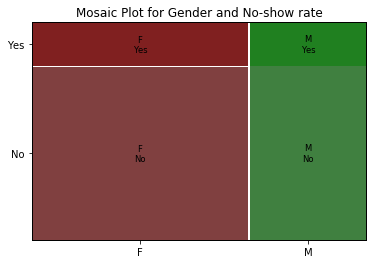

In [75]:
ms = mosaic(record,["Gender", "No-show"], title="Mosaic Plot for Gender and No-show rate")

In [76]:
no_show_dict = {}
show_dict = {}
no_show_dict["F"] = len(record[(record["Gender"] == "F") &(record["No-show"]=="Yes")])
no_show_dict["M"] = len(record[(record["Gender"] == "M") &(record["No-show"]=="Yes")])
show_dict["F"] = len(record[(record["Gender"] == "F") & (record["No-show"]=="No")])
show_dict["M"] = len(record[(record["Gender"] == "M") & (record["No-show"]=="No")])

df_gender_group = pd.DataFrame(data=[no_show_dict,show_dict]).T
df_gender_group.rename(columns={0:'No_Show', 1:"Show"}, inplace=True)
df_gender_group["No_Show_Rate"] = df_gender_group["No_Show"]/(df_gender_group["No_Show"]+df_gender_group["Show"])
df_gender_group

,No_Show,Show,No_Show_Rate
F,14591,57245,0.203115
M,7723,30962,0.199638


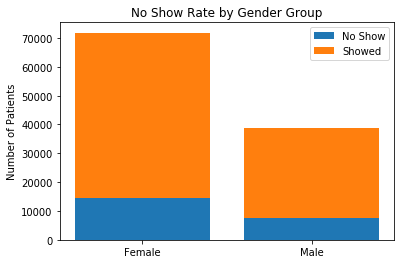

In [77]:
p1 = plt.bar(np.arange(2), df_gender_group["No_Show"])
p2 = plt.bar(np.arange(2), df_gender_group["Show"], bottom=df_gender_group["No_Show"])

plt.title('No Show Rate by Gender Group')
plt.ylabel('Number of Patients')
plt.xticks(np.arange(2), ("Female", "Male"))
plt.legend((p1[0], p2[0]), ('No Show', 'Showed'))

**Conclusion to Q6 and Q7 **

From both the table and the mosaic plot, it seems no show rate is gender independent, which means, no matter you are female or male, the difference of no show rate is insignificant, this matches what is given from the correlation table. Therefore, we can safely guess that Hipertension, Diabetes, Alcoholism and Handcap are slightly negatively correlated to no-show. However, the correlation is small. We would expect to see patients with hipertension, diabetes, alcoholism or handcap show up at their appointment a bit more frequent than those who don't have the diseases, but the difference won't be significant.

On the other hand, Scholarship and SMS received are positively correlated to no-show. If one receives a scholarship or receives an SMS message, the patient is less likely to show up to their appointment. The SMS_received shows a slightly higher correlation than other explanatory variables. This contradicts to my instinct, so I will explore this further.

**Q8: What is the relationship between SMS_received and No-show?**

Text(0.5,1,'Mosaic Plot for SMS_received and No-show Rate')

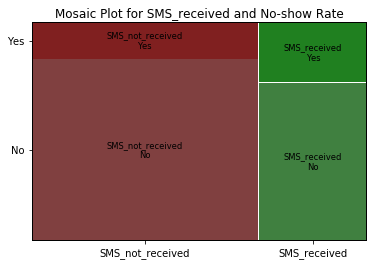

In [97]:
sms_no_show = record[["SMS_received", "No-show"]].copy()
sms_no_show.loc[:,"SMS_received"].replace({0: "SMS_not_received", 1:"SMS_received"}, inplace=True)
ms2 =mosaic(sms_no_show,["SMS_received", "No-show"])
plt.title("Mosaic Plot for SMS_received and No-show Rate")

The mosaic plot tells the same thing as we found from the correlation table. It could be the case that there are too few people received the message, so that the no-show rate for people received SMS has a big margin of error.

In [80]:
sms_no_show =record[["SMS_received","No-show"]].copy()
sms_no_show.loc[:,"show"] = sms_no_show["No-show"]
sms_no_show.loc[:,"show"].replace({"Yes": 0, "No":1}, inplace=True)
sms_no_show.loc[:,"No-show"].replace({"Yes": 1, "No":0}, inplace=True)
sms= sms_no_show.groupby(sms_no_show["SMS_received"]).sum()[["No-show", "show"]]
sms.reset_index(inplace=True)
sms["No-show-rate"] = sms["No-show"] /(sms["No-show"] + sms["show"])
sms["Total-people"] = sms["No-show"] + sms["show"]
sms

,SMS_received,No-show,show,No-show-rate,Total-people
0,0,12530,62509,0.166980,75039
1,1,9784,25698,0.275745,35482


Since the sample size is large, we would expect a small range for 95% confidence intervals.

**Q9: What is the confidence interval for no show rate given SMS-received or not received?**

In [81]:
no_sms = poisson.interval(alpha=0.95, mu=sms.loc[0,"No-show"])/sms.loc[0, "Total-people"]
print ("The upper bound for SMS not received is", str(no_sms[0].round(4)),
      "The lower bound for SMS not receive is", str(no_sms[1].round(4)))

The upper bound for SMS not received is 0.1641 The lower bound for SMS not receive is 0.1699


In [82]:
yes_sms = poisson.interval(alpha=0.95, mu=sms.loc[1,"No-show"])/sms.loc[1, "Total-people"]
print ("The upper bound for SMS received is", str(yes_sms[0].round(4)),
      "The lower bound for SMS receive is", str(yes_sms[1].round(4)))

The upper bound for SMS received is 0.2703 The lower bound for SMS receive is 0.2812


**Q10: How is no-show rate distributed from city to city?**

Now, let's create a heatmap for neighbourhood distribution

Text(0.5,1,'Heatmap for Neighbourhood and No-show Rate')

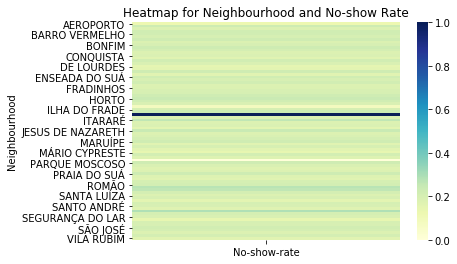

In [83]:
neighbour_no_show =record[["Neighbourhood","No-show"]].copy()
neighbour_no_show.loc[:,"show"] = neighbour_no_show["No-show"]
neighbour_no_show.loc[:,"show"].replace({"Yes": 0, "No":1}, inplace=True)
neighbour_no_show.loc[:,"No-show"].replace({"Yes": 1, "No":0}, inplace=True)
new_df = neighbour_no_show.groupby(neighbour_no_show["Neighbourhood"]).sum()
new_df.loc[:,"total-people"] = new_df["No-show"]+new_df["show"]
new_df.loc[:,"No-show-rate"] = new_df["No-show"]/new_df.loc[:,"total-people"]
heatmap(pd.DataFrame(new_df["No-show-rate"]), cmap="YlGnBu")
plt.title("Heatmap for Neighbourhood and No-show Rate")

According tbo the heatmap, most of the areas have number of people did not show up between 0-250. However, A few areas clearly have higher no-show rate. Let's take a closer look.

In [84]:
new_df.reset_index(inplace=True)

In [85]:
summary_new_df = new_df["No-show-rate"].describe()
summary_new_df

count    81.000000
mean      0.205408
std       0.097235
min       0.000000
25%       0.179907
50%       0.197588
75%       0.217454
max       1.000000
Name: No-show-rate, dtype: float64

Text(0.5,0,'No-show Rate')

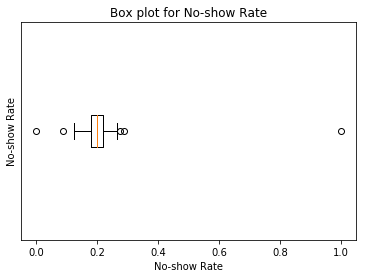

In [89]:
box_plot = plt.boxplot(new_df["No-show-rate"], vert=False)
plt.title("Box plot for No-show Rate")
plt.ylabel("No-show Rate")
plt.yticks(np.arange(1), "")
plt.xlabel("No-show Rate")

In [87]:
upper_bound = summary_new_df["75%"] + 1.5*(summary_new_df["75%"]-summary_new_df["25%"] )
upper_bound
new_df[new_df["No-show-rate"] > upper_bound]

,Neighbourhood,No-show,show,total-people,No-show-rate
34,ILHAS OCEÂNICAS DE TRINDADE,2,0,2,1.000000
61,SANTA CECÍLIA,123,325,448,0.274554
70,SANTOS DUMONT,369,907,1276,0.289185


The upper "whisker" for the box plot is at 0.27, and the neighbourhood with highest no-show rate is ILHAS OCEÂNICAS DE TRINDADE, however, it has a low study population with total record of 2. We would expect the error for this entry is bigger than the cities with higher study population. Hence, I decided to make a barplot with no-show-rate and 95% confidence interval as error bars.

In [183]:
ten_highest_no_show = new_df[new_df["No-show-rate"] > summary_new_df["75%"]][["Neighbourhood", "No-show-rate", "No-show", "total-people"]].sort_values(by="No-show-rate", ascending=False)[:10]
ten_highest_no_show

,Neighbourhood,No-show-rate,No-show,total-people
34,ILHAS OCEÂNICAS DE TRINDADE,1.000000,2,2
70,SANTOS DUMONT,0.289185,369,1276
61,SANTA CECÍLIA,0.274554,123,448
62,SANTA CLARA,0.264822,134,506
36,ITARARÉ,0.262664,923,3514
40,JESUS DE NAZARETH,0.243954,696,2853
28,HORTO,0.240000,42,175
33,ILHA DO PRÍNCIPE,0.234775,532,2266
9,CARATOÍRA,0.230409,591,2565
1,ANDORINHAS,0.230327,521,2262


In [184]:
get_poisson = lambda x: poisson.interval(alpha=0.95, mu=x)
vfunc = np.vectorize(get_poisson)
ten_highest_no_show["Lower"] = vfunc(ten_highest_no_show["No-show"].tolist())[0]/ten_highest_no_show["total-people"]
ten_highest_no_show["Upper"] = vfunc(ten_highest_no_show["No-show"].tolist())[1]/ten_highest_no_show["total-people"]
ten_highest_no_show

,Neighbourhood,No-show-rate,No-show,total-people,Lower,Upper
34,ILHAS OCEÂNICAS DE TRINDADE,1.000000,2,2,0.000000,2.500000
70,SANTOS DUMONT,0.289185,369,1276,0.260188,0.318966
61,SANTA CECÍLIA,0.274554,123,448,0.227679,0.323661
62,SANTA CLARA,0.264822,134,506,0.221344,0.310277
36,ITARARÉ,0.262664,923,3514,0.245874,0.279738
40,JESUS DE NAZARETH,0.243954,696,2853,0.226078,0.262180
28,HORTO,0.240000,42,175,0.171429,0.314286
33,ILHA DO PRÍNCIPE,0.234775,532,2266,0.214916,0.255075
9,CARATOÍRA,0.230409,591,2565,0.212086,0.249123
1,ANDORINHAS,0.230327,521,2262,0.210875,0.250221


(0, 1)

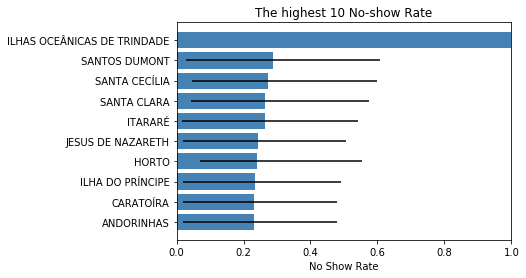

In [282]:
fig, ax = plt.subplots()
error = [ ten_highest_no_show["Lower"], ten_highest_no_show["Upper"],]
y_pos = np.arange(len(ten_highest_no_show))
ax.barh(y_pos, ten_highest_no_show["No-show-rate"], xerr=error,
        color='steelblue')
ax.set_yticks(y_pos)
ax.set_yticklabels(ten_highest_no_show["Neighbourhood"])
ax.invert_yaxis()
ax.set_xlabel('No Show Rate')
ax.set_title('The highest 10 No-show Rate')
plt.xlim([0, 1])

From the bar plot data, the areas with the highest 10 No-show Rate has No-show rate at about 0.25, except ILHAS OCEÂNICAS DE TRINDADE. Other cities have 95% confidence interval from about 0.2 to about 0.4.

# Time Data

**Q12: How does the difference in days in ScheduledDay and AppointmentDay correlate to no-show rate?**

In [135]:
record["ScheduledDay"]=pd.to_datetime(record["ScheduledDay"])
record["AppointmentDay"]=pd.to_datetime(record["AppointmentDay"])

In [136]:
time_diff = record["AppointmentDay"] - record["ScheduledDay"]
record["day_diff"] = time_diff/np.timedelta64(1,'D')
record["day_diff"] = record["day_diff"].apply(np.floor)
record["day_diff"] = record["day_diff"]+1
record[record["day_diff"] <0]

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,day_diff
27033,7.839273e+12,5679978,M,2016-05-10 10:51:53,2016-05-09,38,RESISTÊNCIA,0,0,0,0,1,0,Yes,-1.0
55226,7.896294e+12,5715660,F,2016-05-18 14:50:41,2016-05-17,19,SANTO ANTÔNIO,0,0,0,0,1,0,Yes,-1.0
64175,2.425226e+13,5664962,F,2016-05-05 13:43:58,2016-05-04,22,CONSOLAÇÃO,0,0,0,0,0,0,Yes,-1.0
71533,9.982316e+14,5686628,F,2016-05-11 13:49:20,2016-05-05,81,SANTO ANTÔNIO,0,0,0,0,0,0,Yes,-6.0
72362,3.787482e+12,5655637,M,2016-05-04 06:50:57,2016-05-03,7,TABUAZEIRO,0,0,0,0,0,0,Yes,-1.0


In [57]:
record =  record[record["day_diff"] >= 0]
record["day_diff"].describe()

count    110521.000000
mean         10.184345
std          15.255153
min           0.000000
25%           0.000000
50%           4.000000
75%          15.000000
max         179.000000
Name: day_diff, dtype: float64

In [58]:
IQR = record["day_diff"].describe()["75%"] - record["day_diff"].describe()["25%"]
outlier = record["day_diff"].describe()["75%"] + 1.5*IQR
outlier

37.5

In [59]:
len(record[record["day_diff"] > outlier])/len(record)

0.052505858615104824

Although the documentation says the scheduled day is earlier than appotinment day, there are five entries that appointment day is earlier than scheduled day, and not surprisingly the patient didn't show up for the appointment

In [60]:
np.corrcoef(record['day_diff'], record['No-show-indexed'])[0][1].round(4)

0.1863

The correlation coefficient for day and no-show rate is 0.1868, which means the larger the difference of shceduled day from the appointment day, the patient is less likely to show.

In [61]:
day_diff_df = record[["day_diff", "No-show-indexed"]].copy()
day_diff_df["day_diff_c"] = day_diff_df["day_diff"]
day_diff_df = (day_diff_df.groupby("day_diff_c")
                .agg({"day_diff": 'count', "No-show-indexed":'sum'}))
day_diff_df["no-show-rate"] = (day_diff_df["No-show-indexed"]/day_diff_df["day_diff"])*100
day_diff_df["ratio"] = (day_diff_df["day_diff"]/len(record))*100
day_diff_df[:10]

,day_diff,No-show-indexed,no-show-rate,ratio
day_diff_c,,,,
0.0,38562,1792,4.647062,34.891107
1.0,5213,1113,21.350470,4.716751
2.0,6725,1602,23.821561,6.084816
3.0,2737,644,23.529412,2.476452
4.0,5290,1231,23.270321,4.786421
5.0,3277,872,26.609704,2.965047
6.0,4037,1001,24.795640,3.652699
7.0,4906,1309,26.681614,4.438975
8.0,2332,670,28.730703,2.110006


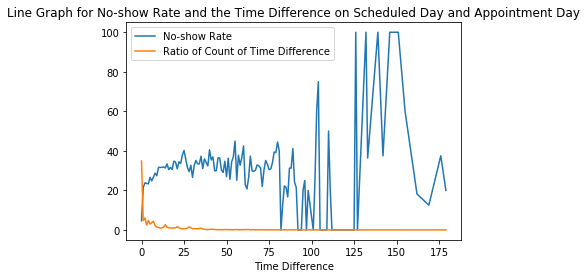

In [62]:
day_diff_df.reset_index(inplace=True)
p3 = plt.plot(day_diff_df["day_diff_c"], day_diff_df["no-show-rate"])
p4 = plt.plot(day_diff_df["day_diff_c"], day_diff_df["ratio"])
plt.title("Line Graph for No-show Rate and the Time Difference on Scheduled Day and Appointment Day")
plt.xlabel("Time Difference")
plt.legend((p3[0], p4[0]), ('No-show Rate', 'Ratio of Count of Time Difference'))
plt.ylabel("No-show Rate/Ratio of Count of Time Difference")

The walk-in people take 34.89% of the total appointment, which is the highest in all day differences. The walk-in appointments also have the lowest no-show-rate of 4.64%. No-show-rate fluctuates more drastically as the the time difference increase. However, the number of appointments drop drastically after 37.5. The no-show rate also increases as the time difference increases.

**Q13: How is no-show rate distributed with date?**

In [63]:
sd = lambda x: x.date()
get_week_day = lambda x: x.weekday()

In [64]:
time_exploration = record[["ScheduledDay", "AppointmentDay", "No-show-indexed"]].copy()
time_exploration["ScheduledDate"] = time_exploration["ScheduledDay"].apply(sd)
time_exploration["ScheduledDayofWeek"] = time_exploration["ScheduledDay"].apply(get_week_day)
time_exploration["ApptDayofWeek"] = time_exploration["AppointmentDay"].apply(get_week_day)
time_exploration.head()

,ScheduledDay,AppointmentDay,No-show-indexed,ScheduledDate,ScheduledDayofWeek,ApptDayofWeek
AppointmentID,,,,,,
5642903,2016-04-29 18:38:08,2016-04-29,0,2016-04-29,4,4
5642503,2016-04-29 16:08:27,2016-04-29,0,2016-04-29,4,4
5642549,2016-04-29 16:19:04,2016-04-29,0,2016-04-29,4,4
5642828,2016-04-29 17:29:31,2016-04-29,0,2016-04-29,4,4
5642494,2016-04-29 16:07:23,2016-04-29,0,2016-04-29,4,4


In [65]:
schedule_date  = (time_exploration.groupby("ScheduledDate")
                 .agg({'ScheduledDay':'count','No-show-indexed': 'sum'})
                 .reset_index()
                .rename( columns={'ScheduledDay':'ScheduledDay_Count'}))
schedule_date["no-show-rate"] = schedule_date["No-show-indexed"]/schedule_date["ScheduledDay_Count"]
schedule_date.loc[:, 'no-show-rate'].describe()

count    111.000000
mean       0.256775
std        0.199894
min        0.000000
25%        0.141744
50%        0.247776
75%        0.346451
max        1.000000
Name: no-show-rate, dtype: float64

The no-show-rate for each day is 25.68%, the first standard deviation from the mean is 5.7% and 45.6% 

Text(0,0.5,'No-show Rate')

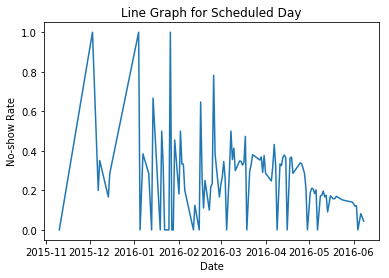

In [66]:
plt.plot(schedule_date["ScheduledDate"], schedule_date["no-show-rate"] )
plt.title("Line Graph for Scheduled Day")
plt.xlabel("Date")
plt.ylabel("No-show Rate")

From the graph shown above, the no show rate from January to February in 2016 has a drastic flutuation. From the middle of February, the no-show rate drops below 20% and then gradually increase to about 40% until April. Then the no-show rate gradually drops till the end of the recording cycle. From the middle of Feburay to the end of the recording cycle, there are on average, two dips, in no-show rate each month. However, since the longitudinal of the time frame is not enough to observe a clearer pattern in the relationship of no-show rate and scheduled date, it is hard to make a conclusion on how the periodicity of the data.

**Q14: How is no-show rate distributed with appointment day?**

In [67]:
time_exploration["appt"] = time_exploration["AppointmentDay"]
appt_date  = (time_exploration.groupby("appt")
                 .agg({'AppointmentDay':'count','No-show-indexed': 'sum'})
                 .reset_index()
                .rename( columns={'AppointmentDay':'ApptDay_Count'}))
appt_date["no-show-rate"] = appt_date["No-show-indexed"]/appt_date["ApptDay_Count"]
appt_date.head()

,appt,ApptDay_Count,No-show-indexed,no-show-rate
0,2016-04-29,3235,633,0.195672
1,2016-05-02,4376,861,0.196755
2,2016-05-03,4255,830,0.195065
3,2016-05-04,4167,972,0.233261
4,2016-05-05,4272,806,0.188670


In [68]:
appt_date.loc[:, 'no-show-rate'].describe()

count    27.000000
mean      0.203157
std       0.018386
min       0.172806
25%       0.189579
50%       0.196822
75%       0.219476
max       0.234848
Name: no-show-rate, dtype: float64

(array([736085., 736092., 736099., 736106., 736113., 736120.]),
 <a list of 6 Text xticklabel objects>)

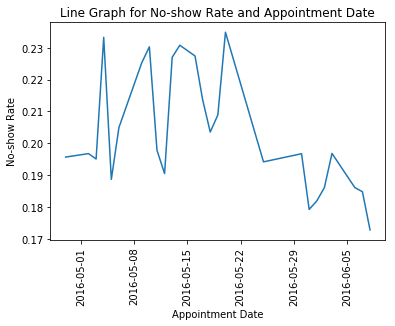

In [69]:
plt.plot(appt_date["appt"], appt_date["no-show-rate"])
plt.title("Line Graph for No-show Rate and Appointment Date")
plt.xlabel("Appointment Date")
plt.ylabel("No-show Rate")
plt.xticks(rotation="vertical")

In [70]:
above_avg = appt_date[appt_date["no-show-rate"] > appt_date.loc[:, 'no-show-rate'].describe()["mean"]].copy()
above_avg["weekday"] = above_avg["appt"].apply(get_week_day)
above_avg

,appt,ApptDay_Count,No-show-indexed,no-show-rate,weekday
3,2016-05-04,4167,972,0.233261,2
5,2016-05-06,3879,795,0.204950,4
6,2016-05-09,4519,1018,0.225271,0
7,2016-05-10,4308,992,0.230269,1
10,2016-05-13,3987,905,0.226988,4
11,2016-05-14,39,9,0.230769,5
12,2016-05-16,4613,1049,0.227401,0
13,2016-05-17,4371,934,0.213681,1
14,2016-05-18,4373,890,0.203522,2
15,2016-05-19,4270,892,0.208899,3


In [225]:
below_avg = appt_date[appt_date["no-show-rate"] < appt_date.loc[:, 'no-show-rate'].describe()["mean"]].copy()
below_avg["weekday"] = below_avg["appt"].apply(get_week_day)
below_avg

,appt,ApptDay_Count,No-show-indexed,no-show-rate,weekday
0,2016-04-29,3235,633,0.195672,4
1,2016-05-02,4376,861,0.196755,0
2,2016-05-03,4255,830,0.195065,1
4,2016-05-05,4272,806,0.188670,3
8,2016-05-11,4474,885,0.197810,2
9,2016-05-12,4394,837,0.190487,3
17,2016-05-24,4009,811,0.202295,1
18,2016-05-25,3909,759,0.194167,2
19,2016-05-30,4514,888,0.196721,0
20,2016-05-31,4279,767,0.179247,1


The no-show rate for scheduled day has mean of 0.20. and there are a few dips and spikes during the first week and the second week of May in 2016. The no-show rate then show a decreasing trend after the the forth week of May. The days that are having higher no-show rate appear to be any day of the week, although Friday, encoded as 4, has higher frequency. For days that are below the mean no-show rate, Tuesday and Wednesday, encoded as 1 and 2, have higher frequncy. However, I do not feel comfortable to make the conclusion that the no-show rate is correlated to the day of the week due to the small sample size.

**Q15: How is no-show rate distributed with what day the scheduled day is in a week?**

In [201]:
time_exploration["Week"] = time_exploration["ScheduledDayofWeek"]
schedule_day_week  = (time_exploration.groupby("Week")
                 .agg({'ScheduledDayofWeek':'count','No-show-indexed': 'sum'})
                 .reset_index()
                .rename( columns={'ScheduledDayofWeek':'Day_Week_Count'}))
schedule_day_week["no-show-rate"] = schedule_day_week["No-show-indexed"]/schedule_day_week["Day_Week_Count"]
schedule_day_week

,Week,Day_Week_Count,No-show-indexed,no-show-rate
0,0,23084,4561,0.197583
1,1,26167,5290,0.202163
2,2,24259,4876,0.200998
3,3,18072,3699,0.204681
4,4,18915,3887,0.205498
5,5,24,1,0.041667


In [202]:
schedule_day_week.loc[:, 'no-show-rate'].describe()

count    6.000000
mean     0.175432
std      0.065592
min      0.041667
25%      0.198436
50%      0.201580
75%      0.204052
max      0.205498
Name: no-show-rate, dtype: float64

([<matplotlib.axis.XTick at 0x1a336ef940>,
 <a list of 6 Text xticklabel objects>)

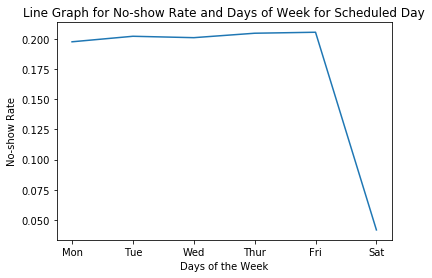

In [234]:
plt.plot(schedule_day_week["no-show-rate"])
plt.title("Line Graph for No-show Rate and Days of Week for Scheduled Day")
plt.xlabel("Days of the Week")
plt.ylabel("No-show Rate")
plt.xticks(np.arange(6), ["Mon", "Tue", "Wed", "Thur", "Fri", "Sat"])

In [204]:
corr_scheduled = np.corrcoef(time_exploration["ScheduledDayofWeek"], 
                             time_exploration["No-show-indexed"])[0][1].round(4)
print ("The correlation coefficient for scheduled day of week is", str(corr_scheduled))

The correlation coefficient for scheduled day of week is 0.006


From the line plot and the calculation of correlation coefficient, there is not a significant difference in no-show rate with respect to what day it is in the week that the appointment is scheduled.

**Q16: How is no-show rate distributed with what day the appointment day is in a week?**

In [205]:
time_exploration["Week_appt"] = time_exploration["ApptDayofWeek"]
appt_day_week  = (time_exploration.groupby("Week_appt")
                 .agg({'ApptDayofWeek':'count','No-show-indexed': 'sum'})
                 .reset_index()
                .rename( columns={'ApptDayofWeek':'Appt_day_count'}))
appt_day_week["no-show-rate"] = appt_day_week["No-show-indexed"]/appt_day_week["Appt_day_count"]
appt_day_week

,Week_appt,Appt_day_count,No-show-indexed,no-show-rate
0,0,22713,4689,0.206446
1,1,25638,5150,0.200874
2,2,25866,5092,0.196861
3,3,17246,3337,0.193494
4,4,19019,4037,0.212261
5,5,39,9,0.230769


([<matplotlib.axis.XTick at 0x1a3373e0b8>,
 <a list of 6 Text xticklabel objects>)

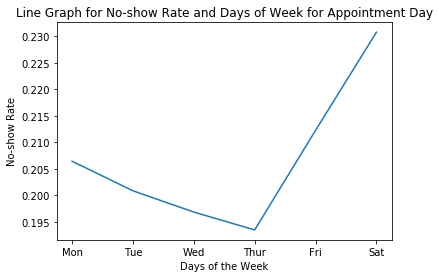

In [235]:
plt.plot(appt_day_week["no-show-rate"])
plt.title("Line Graph for No-show Rate and Days of Week for Appointment Day")
plt.xlabel("Days of the Week")
plt.ylabel("No-show Rate")

plt.xticks(np.arange(6), ["Mon", "Tue", "Wed", "Thur", "Fri", "Sat"])

In [207]:
appt_day_corr = np.corrcoef(time_exploration["ApptDayofWeek"], time_exploration["No-show-indexed"])[0][1].round(4)
print ("The correlation coefficient for scheduled day of week is", str(appt_day_corr))

The correlation coefficient for scheduled day of week is 0.0012


From the line plot and the calculation of correlation coefficient, there is not a significant difference in no-show rate with respect to what day it is in the week. However, the correlation is a little bit weeaker than that of scheduled date. This possibly because most of the patients are not in urgent, and they can fill in the available spot later that week. The patients usually fill in the clinic quite quickly, and 

The two line graphs on day of the week of appointment day and scheduled day shows the no-show rate is the lowest when the appointment is made on Saturdays, and is the lowest when the actual appointment is on Thursday. However, the correlation of no-show rate and the day of the week is low, which is 0.006 for scheduled day and 0.0012 for appointment day, which means the day of the week is almost independent to no-show rate.

# Conclusion

To answer the overall question *What factors are important for us to know in order to predict if a patient will show up for their scheduled appointment?*, the report has investigated on patientID, age, categorical variables, and time series data.

In the investigation of patientID, the result show 92% of the patients visit the clinic under three times during the given time frame, and the a person's visits takes smaller portion of the appointments as this person is a more frequent visitor to the clinic. Setting the threshold as 3, the correlation coeffcient for frequent visitors and no-show rate is 0.0145, slightly positive correlated to no-show rate. This result means, if a person goes to a clinic more than three times, this person is more likely to not show in an appointment.

When looking at no-show rate with age, the ages are divided into every 20 years. The correlation coefficient for age groups is -0.0635 and -0.0605 when comparing to numerical age, which means the older the person is, the more likely this person will show up for the appointment. The mosaic plot shows, in the range of 0 to 79, people in age groups of 0-19 and 20-39 have higher no-show rate than people in the other two age groups. There is also a clear decrease in no-show rate when the age shifts from 40-59 to 60-79.

The categorical variables, Gender, Scholarship, Hipertension, Diabetes and Alcoholism are almost independent to no-show rate, as their correlation with no-show rate is between 0.05 to -0.05. SMS received, however, has a better correlation comparing to other categorical variables, with 0.13 correlation coefficient. The mosaic plot shows a visually significant difference in the possibility of no-show with given SMS is received or not. 

As for the time data, the correlation coefficient for difference in appointment day and scheduled day and no-show rate is 0.1868, which means the larger the difference of shceduled day from the appointment day, the patient is less likely to show. The no-show rate also shows an decreasing trend if the appointment is made after March in 2016, and the apoointments on some day thtat is after the third week of May, 2016. Other factors such as the day of the week that the appointment is scheduled or the actual appointment is independent from no-show rate given the data set.

## Data Quality and Limitations

This dataset, however, has a few drawbacks that may affect the data quality. 

1. There is one row of entry that has age under 0.
2. Five entries having scheduled day later than appointment day.
3. Handicap is not binary, but SMS_received is binary which are different from the dictionary
5. The line graph for appointment date shows only about five weeks of data has been collected, and the time span is not long enough to demonstrate a trend in no-show rate with respect to time.
    1. Since only five months of data is shown, a patient visiting a clinic more than 40 times does not sound rational. It is hard to imagine a person needs to go to the clinic more than once a day. The accuracy of the data may need to be checked again for those frequent visitors.
    
    
The data dictionary should be updated for better accuracy in response to 1, 2 and 3. If one wishes to grasp a better understanding of no-show rate change with respect to time, entries from longer time frame should be analyzed.